# Aviation Accidents Analysis

You are part of a consulting firm that is tasked to do an analysis of commercial and passenger jet airline safety. The client (an airline/airplane insurer) is interested in knowing what types of aircraft (makes/models) exhibit low rates of total destruction and low likelihood of fatal or serious passenger injuries in the event of an accident. They are also interested in any general variables/conditions that might be at play. Your analysis will be based off of aviation accident data accumulated from the years 1948-2023. 

Our client is only interested in airplane makes/models that are professional builds and could potentially still be active. Assume a max lifetime of 40 years for a make/model retirement and make sure to filter your data accordingly (i.e. from 1983 onwards). They would also like separate recommendations for small aircraft vs. larger passenger models. **In addition, make sure that claims that you make are statistically robust and that you have enough samples when making comparisons between groups.**


In this summative assessment you will demonstrate your ability to:
- Use Pandas to load, inspect, and clean the dataset appropriately. 
- Transform relevant columns to create measures that address the problem at hand.
- **conduct EDA: visualization and statistical measures to understand the structure of the data**
- **recommend a set of manufacturers to consider as well as specific airplanes conforming to the client's request**
- **discuss the relationship between serious injuries/airplane damage incurred and at least *two* factors at play in the incident. You must provide supporting evidence (visuals, summary statistics, tables) for each claim you make.**

In [119]:
# loading relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Exploratory Data Analysis  
- Load in the cleaned data

In [120]:
aviation_df = pd.read_csv('AviationData_cleaned.csv',
    encoding='latin1',
    index_col=0
)

C:\Users\steve\AppData\Local\Temp\ipykernel_10264\1184600645.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  aviation_df = pd.read_csv('AviationData_cleaned.csv',


In [121]:
aviation_df.columns

Index(['Investigation.Type', 'Event.Date', 'Injury.Severity',
       'Aircraft.damage', 'Make', 'Model', 'Amateur.Built',
       'Number.of.Engines', 'Engine.Type', 'Purpose.of.flight',
       'Total.Fatal.Injuries', 'Total.Serious.Injuries',
       'Total.Minor.Injuries', 'Total.Uninjured', 'Weather.Condition',
       'Broad.phase.of.flight', 'Total.Passengers',
       'Total.Fatal/Serious_injuries', 'Aircraft.destroyed',
       'Aircraft.Make_Model'],
      dtype='object')

## Explore safety metrics across models/makes
- Remember that the client is interested in separate recommendations for smaller airplanes and larger airplanes. Choose a passenger threshold of 20 and separate the plane types. 

In [122]:
# Step 1: Group by Make and calculate sum of Total.Passengers and count of flights
make_stats = aviation_df.groupby('Make').agg(
    Total_Passengers_Sum=('Total.Passengers', 'sum'),
    Flight_Count=('Event.Date', 'count')
)

# Step 2: Calculate average passengers per flight per make
make_stats['Avg_Passengers_Per_Flight'] = make_stats['Total_Passengers_Sum'] / make_stats['Flight_Count']

# Step 3: Determine Aircraft.Size per Make
make_stats['Aircraft.Size'] = np.where(
    make_stats['Avg_Passengers_Per_Flight'] <= 20,
    'Small',
    'Large'
)

# Step 4: Map this Aircraft.Size back to the original DataFrame by Make
aviation_df['Aircraft.Size'] = aviation_df['Make'].map(make_stats['Aircraft.Size'])

In [123]:
make_size_df = aviation_df[['Make', 'Aircraft.Size']].drop_duplicates()
make_size_df = make_size_df.sort_values(by='Make').reset_index(drop=True)
print(make_size_df)

                             Make Aircraft.Size
0                  Aero Commander         Small
1                         Aeronca         Small
2                    Aerospatiale         Small
3                     Air Tractor         Small
4                          Airbus         Large
5                Airbus Industrie         Large
6                             Atr         Large
7                   Balloon Works         Small
8                           Beech         Small
9                            Bell         Small
10                       Bellanca         Small
11                         Boeing         Large
12                     Bombardier         Large
13              British Aerospace         Large
14                       Canadair         Small
15                         Cessna         Small
16                       Champion         Small
17             Cirrus Design Corp         Small
18                    Dehavilland         Small
19                        Dornier       

#### Analyzing Makes

Explore the human injury risk profile for small and larger Makes:
- choose the 15 makes for each group possessing the lowest mean fatal/seriously injured fraction
- plot the mean fatal/seriously injured fraction for each of these subgroups side-by-side

In [124]:
# Group by Aircraft.Size and Make
injury_stats = aviation_df.groupby(['Aircraft.Size', 'Make']).agg(
    Total_Fatal_Serious=('Total.Fatal/Serious_injuries', 'sum'),
    Incident_Count=('Event.Date', 'count')  # or 'Event.Id' if available
).reset_index()

# Calculate mean fatal/serious injuries per event
injury_stats['Avg_Injuries_Per_Incident'] = injury_stats['Total_Fatal_Serious'] / injury_stats['Incident_Count']

# Separate top 15 safest small and large aircraft makes
top_small = injury_stats[injury_stats['Aircraft.Size'] == 'Small'].nsmallest(15, 'Avg_Injuries_Per_Incident')
top_large = injury_stats[injury_stats['Aircraft.Size'] == 'Large'].nsmallest(15, 'Avg_Injuries_Per_Incident')


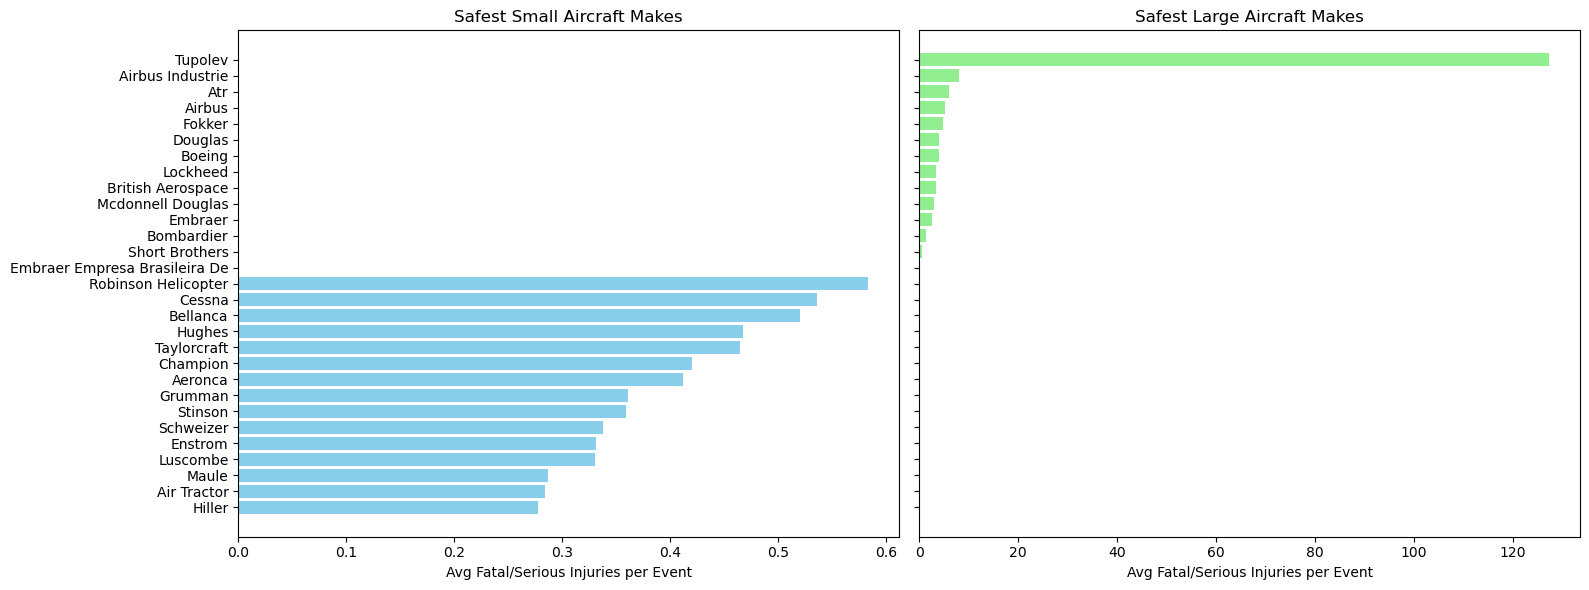

In [125]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Small Aircraft
axes[0].barh(top_small['Make'], top_small['Avg_Injuries_Per_Incident'], color='skyblue')
axes[0].set_title('Safest Small Aircraft Makes')
axes[0].set_xlabel('Avg Fatal/Serious Injuries per Event')
axes[0].invert_yaxis()

# Large Aircraft
axes[1].barh(top_large['Make'], top_large['Avg_Injuries_Per_Incident'], color='lightgreen')
axes[1].set_title('Safest Large Aircraft Makes')
axes[1].set_xlabel('Avg Fatal/Serious Injuries per Event')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

**Distribution of injury rates: small makes**

Use a violinplot to look at the distribution of the fraction of passengers serious/fatally injured for small airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

C:\Users\steve\AppData\Local\Temp\ipykernel_10264\2578673250.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=small_df, x='Make', y='Fatal_Serious_Rate', inner='quartile', palette='pastel')


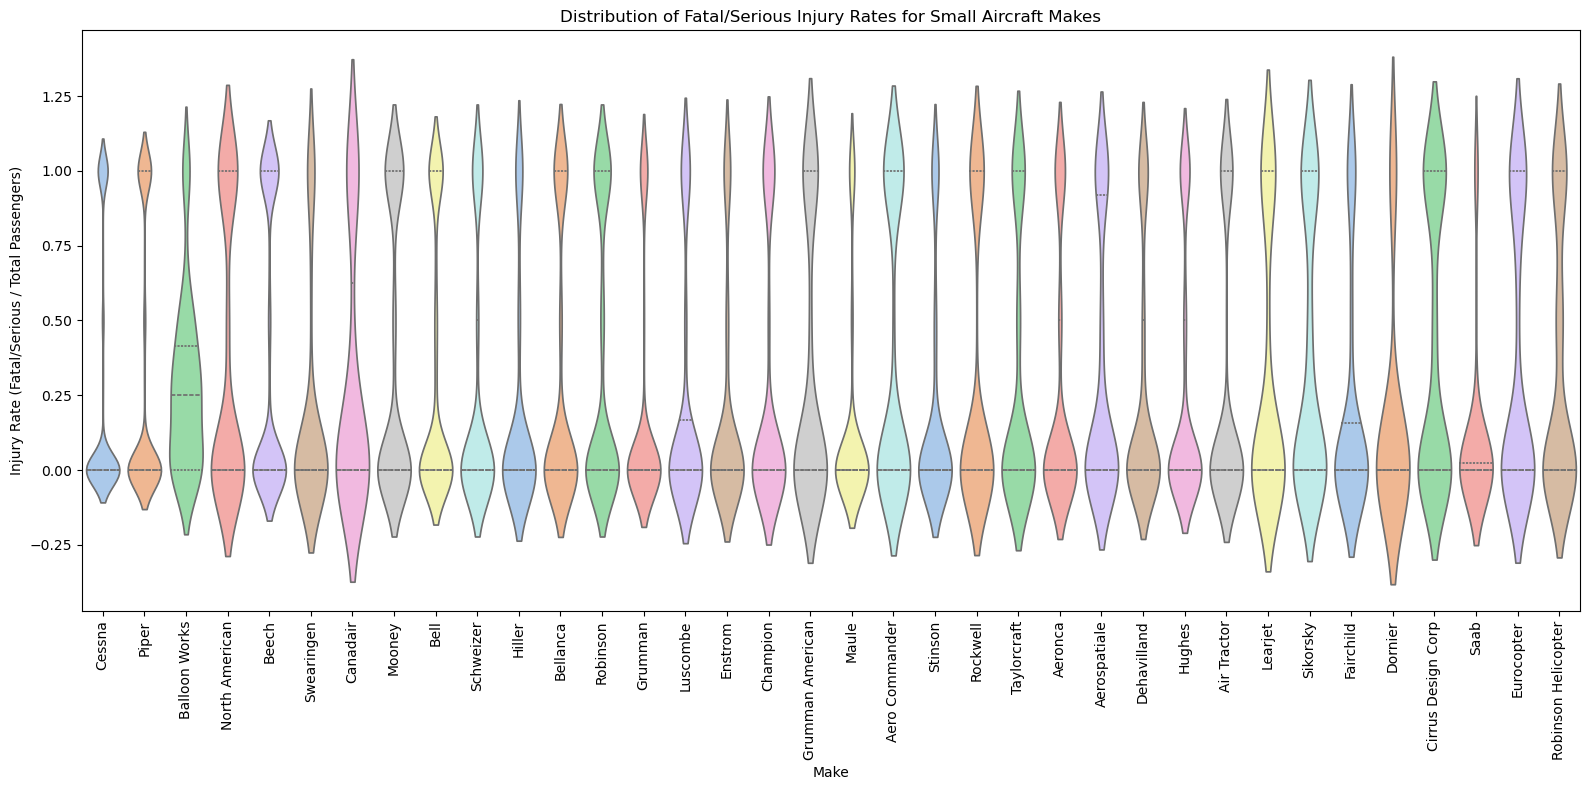

In [126]:
# Step 1: Filter to only small aircraft with valid values
small_df = aviation_df[
    (aviation_df['Aircraft.Size'] == 'Small') &
    (aviation_df['Total.Passengers'] > 0)
].copy()

# Step 2: Calculate the injury rate per row
small_df['Fatal_Serious_Rate'] = (
    small_df['Total.Fatal/Serious_injuries'] / small_df['Total.Passengers']
).replace([np.inf, -np.inf], np.nan)

# Step 3: Drop invalid injury rates
small_df = small_df.dropna(subset=['Fatal_Serious_Rate'])

# Step 4: Filter to makes with enough data (optional, e.g. 10+ incidents)
make_counts = small_df['Make'].value_counts()
valid_makes = make_counts[make_counts >= 10].index  # change 10 to another threshold if needed
small_df = small_df[small_df['Make'].isin(valid_makes)]

# Step 5: Plot
plt.figure(figsize=(16, 8))
sns.violinplot(data=small_df, x='Make', y='Fatal_Serious_Rate', inner='quartile', palette='pastel')
plt.xticks(rotation=90)
plt.title('Distribution of Fatal/Serious Injury Rates for Small Aircraft Makes')
plt.ylabel('Injury Rate (Fatal/Serious / Total Passengers)')
plt.xlabel('Make')
plt.tight_layout()
plt.show()

**Distribution of injury rates: large makes**

Use a stripplot to look at the distribution of the fraction of passengers serious/fatally injured for large airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

C:\Users\steve\AppData\Local\Temp\ipykernel_10264\2902109873.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=large_df, x='Make', y='Fatal_Serious_Rate', jitter=True, palette='Set2')


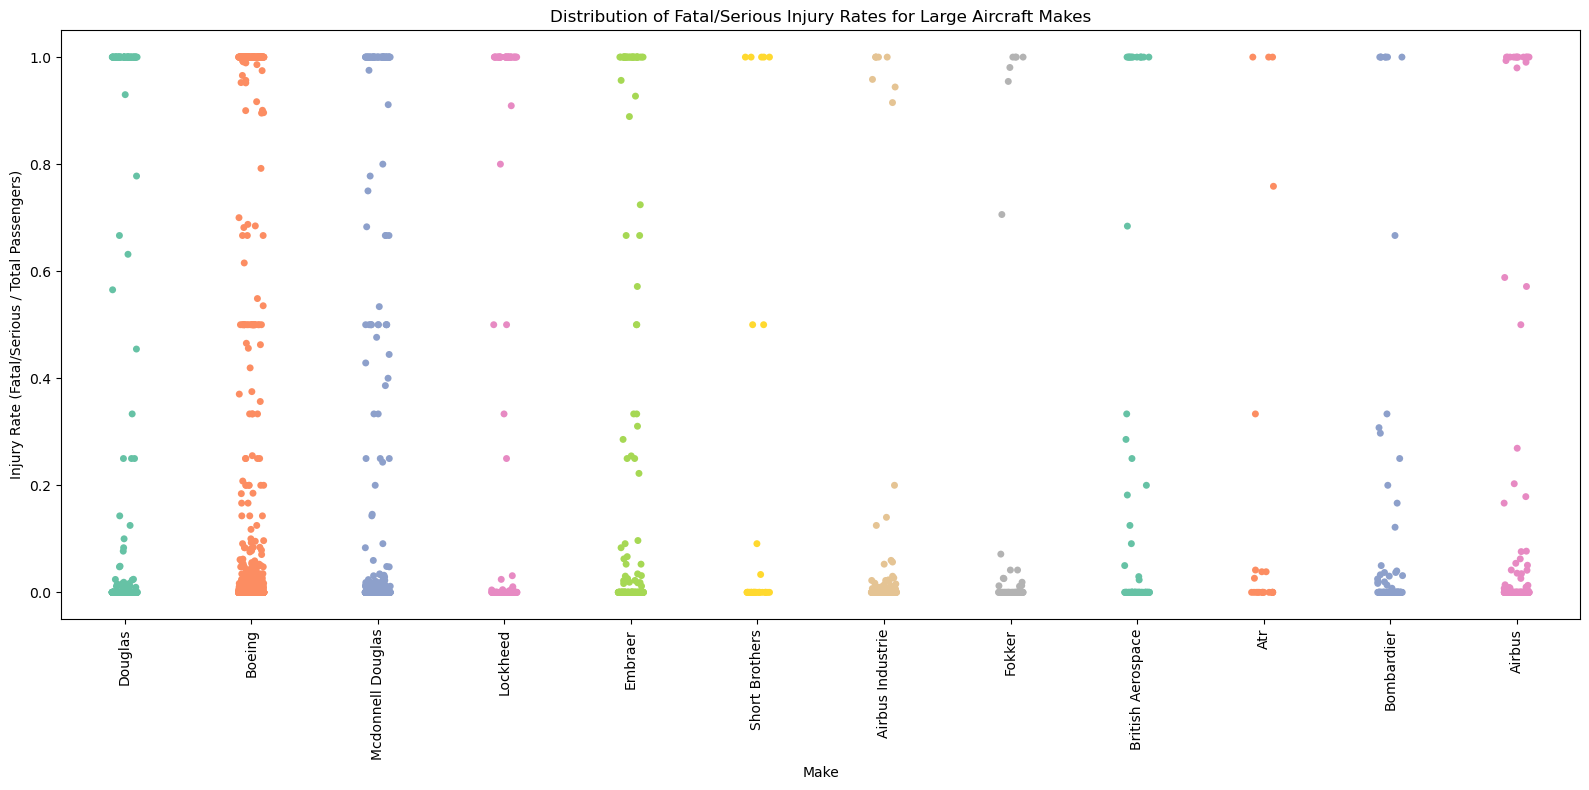

In [127]:
# Step 1: Filter to only large aircraft with valid passengers
large_df = aviation_df[
    (aviation_df['Aircraft.Size'] == 'Large') &
    (aviation_df['Total.Passengers'] > 0)
].copy()

# Step 2: Calculate the injury rate per row
large_df['Fatal_Serious_Rate'] = (
    large_df['Total.Fatal/Serious_injuries'] / large_df['Total.Passengers']
).replace([np.inf, -np.inf], np.nan)

# Step 3: Drop invalid injury rates
large_df = large_df.dropna(subset=['Fatal_Serious_Rate'])

# Step 4: Optional — only include makes with enough records (e.g., at least 10 incidents)
make_counts = large_df['Make'].value_counts()
valid_makes = make_counts[make_counts >= 10].index  # adjust threshold as needed
large_df = large_df[large_df['Make'].isin(valid_makes)]

# Step 5: Plot
plt.figure(figsize=(16, 8))
sns.stripplot(data=large_df, x='Make', y='Fatal_Serious_Rate', jitter=True, palette='Set2')
plt.xticks(rotation=90)
plt.title('Distribution of Fatal/Serious Injury Rates for Large Aircraft Makes')
plt.ylabel('Injury Rate (Fatal/Serious / Total Passengers)')
plt.xlabel('Make')
plt.tight_layout()
plt.show()

**Evaluate the rate of aircraft destruction for both small and large aircraft by Make.** 

Sort your results and keep the lowest 15.

In [128]:
aviation_df.columns

Index(['Investigation.Type', 'Event.Date', 'Injury.Severity',
       'Aircraft.damage', 'Make', 'Model', 'Amateur.Built',
       'Number.of.Engines', 'Engine.Type', 'Purpose.of.flight',
       'Total.Fatal.Injuries', 'Total.Serious.Injuries',
       'Total.Minor.Injuries', 'Total.Uninjured', 'Weather.Condition',
       'Broad.phase.of.flight', 'Total.Passengers',
       'Total.Fatal/Serious_injuries', 'Aircraft.destroyed',
       'Aircraft.Make_Model', 'Aircraft.Size'],
      dtype='object')

In [129]:
# Filter for Large aircraft only
large_df = aviation_df[aviation_df['Aircraft.Size'] == 'Large']

# Group by Make
large_stats = large_df.groupby('Make').agg(
    Total_Accidents=('Aircraft.destroyed', 'count'),
    Total_Destroyed=('Aircraft.destroyed', 'sum')
).reset_index()

# Add Destruction Rate and Ratio
large_stats['Destruction_Rate'] = large_stats['Total_Destroyed'] / large_stats['Total_Accidents']
large_stats['Accidents_per_Destroyed'] = large_stats['Total_Accidents'] / large_stats['Total_Destroyed']
large_stats.replace([np.inf, -np.inf], np.nan, inplace=True)

# Filter to makes with at least 10 accidents
large_stats = large_stats[large_stats['Total_Accidents'] >= 10]

# Get 15 makes with lowest destruction rate and sort
lowest_large = large_stats.nsmallest(15, 'Destruction_Rate').sort_values(by='Destruction_Rate')
print("Lowest Destruction Rate – Large Aircraft:\n")
print(lowest_large)

Lowest Destruction Rate – Large Aircraft:

                 Make  Total_Accidents  Total_Destroyed  Destruction_Rate  \
4          Bombardier              168                7          0.041667   
0              Airbus              291               14          0.048110   
3              Boeing             2696              164          0.060831   
1    Airbus Industrie              164               11          0.067073   
9              Fokker               64                6          0.093750   
11  Mcdonnell Douglas              610               76          0.124590   
7             Embraer              236               31          0.131356   
12     Short Brothers               35                6          0.171429   
5   British Aerospace               90               18          0.200000   
2                 Atr               35                8          0.228571   
6             Douglas              267               64          0.239700   
10           Lockheed            

In [130]:
# Filter for Small aircraft only
small_df = aviation_df[aviation_df['Aircraft.Size'] == 'Small']

# Group by Make
small_stats = small_df.groupby('Make').agg(
    Total_Accidents=('Aircraft.destroyed', 'count'),
    Total_Destroyed=('Aircraft.destroyed', 'sum')
).reset_index()

# Add Destruction Rate and Ratio
small_stats['Destruction_Rate'] = small_stats['Total_Destroyed'] / small_stats['Total_Accidents']
small_stats['Accidents_per_Destroyed'] = small_stats['Total_Accidents'] / small_stats['Total_Destroyed']
small_stats.replace([np.inf, -np.inf], np.nan, inplace=True)

# Filter to makes with at least 10 accidents
small_stats = small_stats[small_stats['Total_Accidents'] >= 10]

# Get 15 makes with lowest destruction rate and sort
lowest_small = small_stats.nsmallest(15, 'Destruction_Rate').sort_values(by='Destruction_Rate')
print("\nLowest Destruction Rate – Small Aircraft:\n")
print(lowest_small)


Lowest Destruction Rate – Small Aircraft:

                   Make  Total_Accidents  Total_Destroyed  Destruction_Rate  \
30                 Saab               66                3          0.045455   
28  Robinson Helicopter              230               14          0.060870   
4         Balloon Works              139                9          0.064748   
23                Maule              572               54          0.094406   
22             Luscombe              391               41          0.104859   
35          Taylorcraft              366               45          0.122951   
33              Stinson              421               56          0.133017   
1               Aeronca              607               84          0.138386   
31            Schweizer              756              109          0.144180   
14              Enstrom              281               41          0.145907   
10             Champion              507               79          0.155819   
12      

#### Provide a short discussion on your findings for your summary statistics and plots:
- Make any recommendations for Makes here based off of the destroyed fraction and fraction fatally/seriously injured
- Comment on the calculated statistics and any corresponding distributions you have visualized.

In [ ]:
#We can conclude that Saab is the saftest based on destruction rate for small planes 
#Bombadier is the saftest based on large planes

### Analyze plane types
- plot the mean fatal/seriously injured fraction for both small and larger planes 
- also provide a distributional plot of your choice for the fatal/seriously injured fraction by airplane type (stripplot, violin, etc)  
- filter ensuring that you have at least ten individual examples in each model/make to average over

**Larger planes**

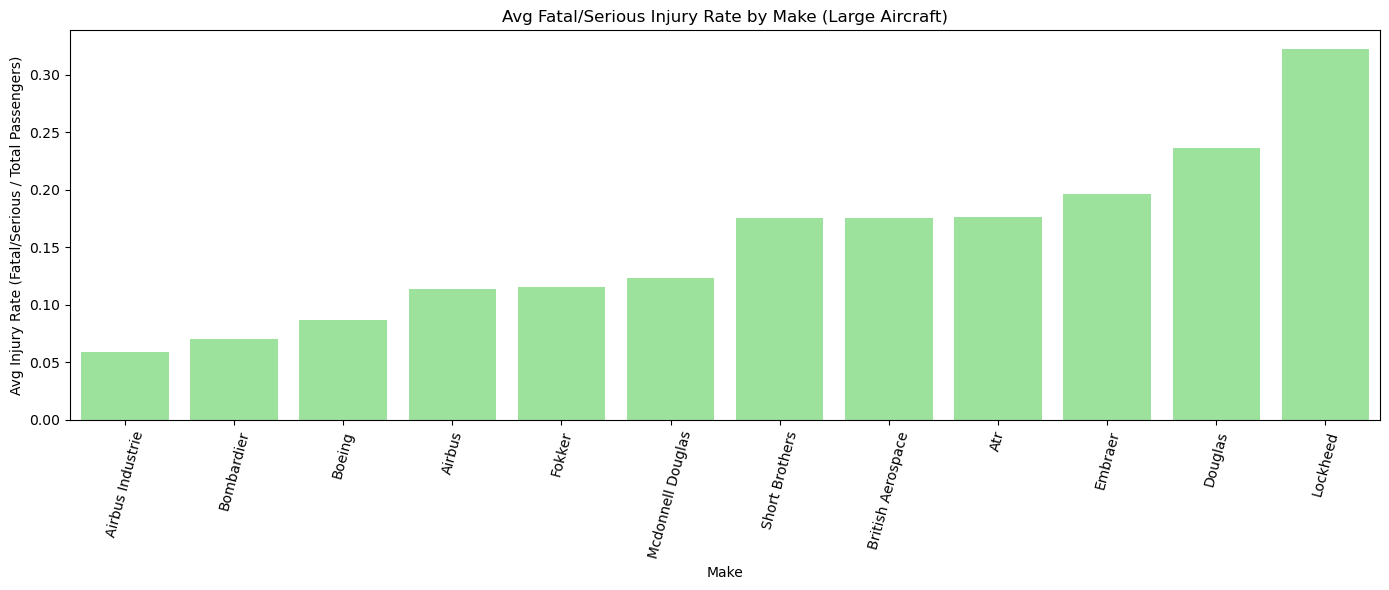

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Filter base dataset
base_df = aviation_df[
    (aviation_df['Total.Passengers'] > 0) &
    (aviation_df['Make'].notna()) &
    (aviation_df['Aircraft.Size'].isin(['Small', 'Large']))
].copy()

# Step 2: Compute fatal/serious rate per row
base_df['Fatal_Serious_Rate'] = base_df['Total.Fatal/Serious_injuries'] / base_df['Total.Passengers']

# Step 3: Plot function
def plot_bar_by_size(df, size_label, color):
    size_df = df[df['Aircraft.Size'] == size_label]
    
    # Only keep Makes with at least 10 entries
    valid_makes = size_df['Make'].value_counts()
    size_df = size_df[size_df['Make'].isin(valid_makes[valid_makes >= 10].index)]
    
    # Group by Make to compute average fatal/serious injury rate
    make_avg = size_df.groupby('Make')['Fatal_Serious_Rate'].mean().reset_index()
    
    # Sort values for better visualization
    make_avg = make_avg.sort_values(by='Fatal_Serious_Rate', ascending=True)
    
    # Plot
    plt.figure(figsize=(14, 6))
    sns.barplot(data=make_avg, x='Make', y='Fatal_Serious_Rate', color=color)
    plt.xticks(rotation=75)
    plt.title(f'Avg Fatal/Serious Injury Rate by Make ({size_label} Aircraft)')
    plt.ylabel('Avg Injury Rate (Fatal/Serious / Total Passengers)')
    plt.xlabel('Make')
    plt.tight_layout()
    plt.show()

#Plot for Large Aircraft
plot_bar_by_size(base_df, 'Large', 'lightgreen')

**Smaller planes**
- for smaller planes, limit your plotted results to the makes with the 10 lowest mean serious/fatal injury fractions

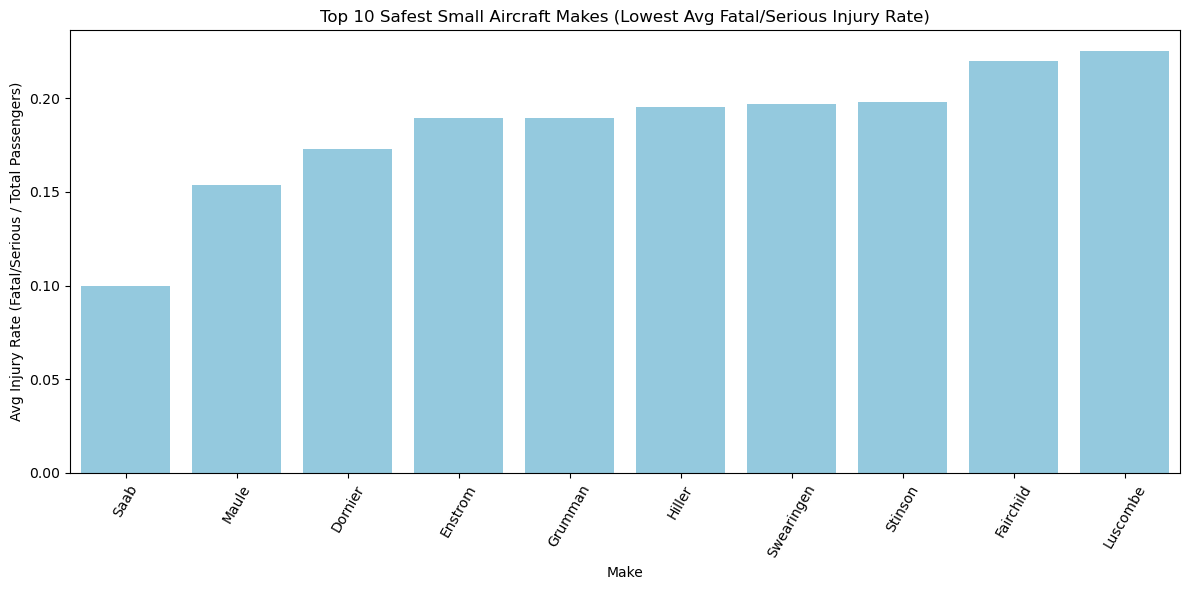

In [148]:
# Step 1: Filter base dataset
small_df = aviation_df[
    (aviation_df['Total.Passengers'] > 0) &
    (aviation_df['Make'].notna()) &
    (aviation_df['Aircraft.Size'] == 'Small')
].copy()

# Step 2: Calculate per-row injury rate
small_df['Fatal_Serious_Rate'] = small_df['Total.Fatal/Serious_injuries'] / small_df['Total.Passengers']

# Step 3: Filter to makes with ≥10 incidents
valid_makes = small_df['Make'].value_counts()
small_df = small_df[small_df['Make'].isin(valid_makes[valid_makes >= 10].index)]

# Step 4: Group by Make and calculate mean rate
make_avg_small = small_df.groupby('Make')['Fatal_Serious_Rate'].mean().reset_index()

# Step 5: Sort and select 10 lowest-risk makes
make_avg_small = make_avg_small.sort_values(by='Fatal_Serious_Rate', ascending=True).head(10)

# Step 6: Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=make_avg_small, x='Make', y='Fatal_Serious_Rate', color='skyblue')
plt.xticks(rotation=60)
plt.title('Top 10 Safest Small Aircraft Makes (Lowest Avg Fatal/Serious Injury Rate)')
plt.ylabel('Avg Injury Rate (Fatal/Serious / Total Passengers)')
plt.xlabel('Make')
plt.tight_layout()
plt.show()


### Discussion of Specific Airplane Types
- Discuss what you have found above regarding passenger fraction seriously/ both small and large airplane models.

In [ ]:
#The 3 large aircrafts have a safer Fatality/Seriously injury rate than the small aircrafts

### Exploring Other Variables
- Investigate how other variables effect aircraft damage and injury. You must choose **two** factors out of the following but are free to analyze more:

- Weather Condition
- Engine Type
- Number of Engines
- Phase of Flight
- Purpose of Flight

For each factor provide a discussion explaining your analysis with appropriate visualization / data summaries and interpreting your findings.

C:\Users\steve\AppData\Local\Temp\ipykernel_10264\1943492315.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped.sort_values('Fatal_Serious_Rate', ascending=False),


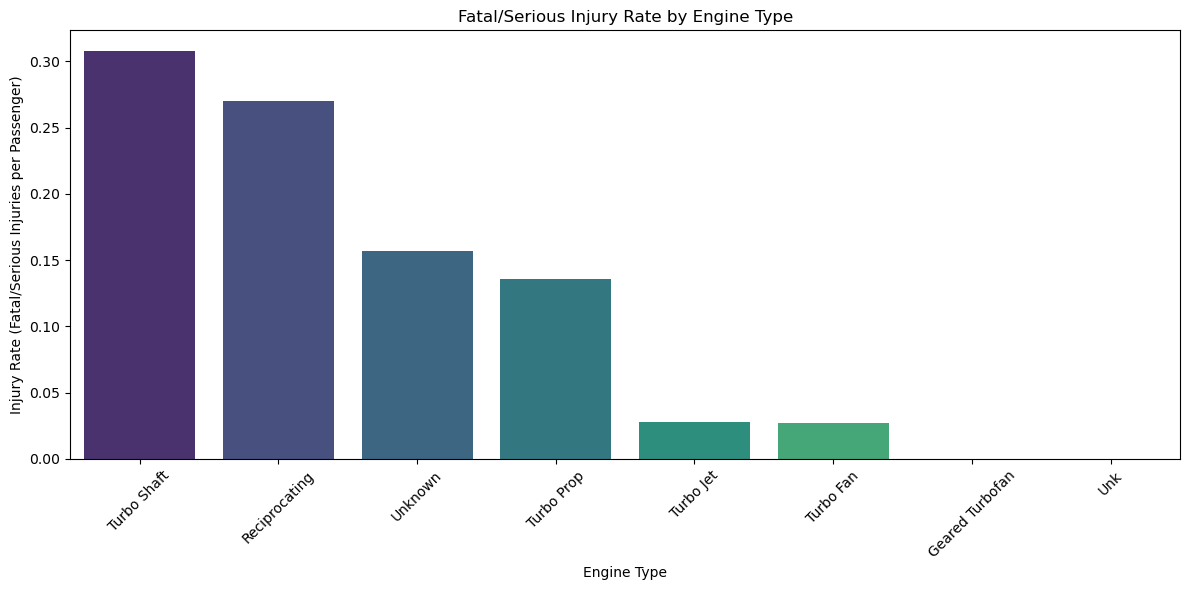

In [158]:
# Filter valid rows
engine_type_df = aviation_df[
    aviation_df['Engine.Type'].notna() &
    aviation_df['Total.Passengers'].notna() &
    (aviation_df['Total.Passengers'] > 0) &
    aviation_df['Total.Fatal/Serious_injuries'].notna()
].copy()

# Group and calculate total injuries and total passengers
grouped = (
    engine_type_df
    .groupby('Engine.Type')[['Total.Fatal/Serious_injuries', 'Total.Passengers']]
    .sum()
    .reset_index()
)

# Manually calculate the injury rate
grouped['Fatal_Serious_Rate'] = grouped['Total.Fatal/Serious_injuries'] / grouped['Total.Passengers']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped.sort_values('Fatal_Serious_Rate', ascending=False),
            x='Engine.Type', y='Fatal_Serious_Rate', palette='viridis')
plt.title('Fatal/Serious Injury Rate by Engine Type')
plt.ylabel('Injury Rate (Fatal/Serious Injuries per Passenger)')
plt.xlabel('Engine Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#There is a correlation where planes with a Turbo Shaft or Reciprocating 
# engine type have a higher fatality/serious injury rate
aviation_df.columns

Index(['Investigation.Type', 'Event.Date', 'Injury.Severity',
       'Aircraft.damage', 'Make', 'Model', 'Amateur.Built',
       'Number.of.Engines', 'Engine.Type', 'Purpose.of.flight',
       'Total.Fatal.Injuries', 'Total.Serious.Injuries',
       'Total.Minor.Injuries', 'Total.Uninjured', 'Weather.Condition',
       'Broad.phase.of.flight', 'Total.Passengers',
       'Total.Fatal/Serious_injuries', 'Aircraft.destroyed',
       'Aircraft.Make_Model', 'Aircraft.Size', 'Fatal_Serious_Rate'],
      dtype='object')